In [1]:
import src
from src.slurm import init_signal_handler, init_distributed_mode
from src.utils import bool_flag, initialize_exp
from src.model import check_model_params, build_modules
from src.envs import ENVS, build_env
from src.envs.char_sp import EnvDataset
from src.trainer import Trainer
from src.evaluator import Evaluator

from egraph import exp, log, sqrt, sign
from egraph import sin, cos, tan, cot
from egraph import sinh, cosh, tanh, coth
from egraph import asin, acos, atan, acot
from egraph import asinh, acosh, atanh
from egraph import expression, EGraph, Node, Rule, apply_rules

import math
from math import pi
from graphviz import Digraph

from abc import ABC
from typing import (
    Any,
    Callable,
    Dict,
    Iterable,
    Iterator,
    List,
    NamedTuple,
    Optional,
    Set,
    Tuple,
    TypeVar,
    Union,
)

In [ ]:
from src.utils import AttrDict
model_path = 'save/ode1_baseline/ode1.pth'

params = params = AttrDict({
    # environment parameters
    'env_name': 'char_sp',
    'int_base': 10,
    'balanced': False,
    'positive': True,
    'precision': 10,
    'n_variables': 1,
    'n_coefficients': 0,
    'leaf_probs': '0.75,0,0.25,0',
    'max_len': 512,
    'max_int': 5,
    'max_ops': 15,
    'max_ops_G': 15,
    'clean_prefix_expr': True,
    'rewrite_functions': '',
    'tasks': 'ode1',
    'operators': 'add:10,sub:3,mul:10,div:5,sqrt:4,pow2:4,pow3:2,pow4:1,pow5:1,ln:4,exp:4,sin:4,cos:4,tan:4,asin:1,acos:1,atan:1,sinh:1,cosh:1,tanh:1,asinh:1,acosh:1,atanh:1',

    # model parameters
    'cpu': False,
    'emb_dim': 1024,
    'n_enc_layers': 6,
    'n_dec_layers': 6,
    'n_heads': 8,
    'dropout': 0,
    'attention_dropout': 0,
    'sinusoidal_embeddings': False,
    'share_inout_emb': True,
    'reload_model': model_path,

    'epoch_size': 300000,
    'reload_data': 'ode1,/home/ewen/data/math/ode1.train,/home/ewen/data/math/ode1.valid,/home/ewen/data/math/ode1.test',
    'reload_size': 1000000,
    'fp16': True,
    'amp': 2,
    'multi_gpu': False,
    'optimizer': 'adam,lr=0.0001',
    'stopping_criterion': '',
    'validation_metrics': 'valid_prim_fwd_acc',
    'dump_path': 'garbage',
    'reload_checkpoint': '',
    'export_data': False,
    'eval_only': False,
    'env_base_seed': 0,
    'batch_size': 32,
    'global_rank': 0,
    'num_workers': 10,
    'same_nb_ops_per_batch': False,
    'n_gpu_per_node': 1,
    'local_rank': 0,
})

env = build_env(params)
modules = build_modules(env, params)
trainer = Trainer(modules, env, params)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [ ]:
infix_list = []
words = set()
dataloader = env.create_train_iterator('ode1', params, trainer.data_path)
dataset = dataloader.dataset
print(len(dataset.data))

def replace_y(prefix_str):
    return prefix_str.replace("Y'", 'z').replace('Y', 'y')

def replace_log_e(prefix_str):
    return prefix_str.replace('ln', 'log').replace('E', 'math.e')

infix_errors = []
interested_item = []
for index, item in enumerate(dataset.data):
    prefix = item[0].split()
    words.update(prefix)
    processed_prefix = replace_y(item[0])
    try:
        infix = env.prefix_to_infix(processed_prefix.split())
        infix = infix.replace('Abs', 'abs')
        infix = replace_log_e(infix)
        infix_list.append(infix)
        if 'E' in infix:
            interested_item.append((index, item))
    except:
        infix_errors.append((index, item))
        continue

1000000


In [ ]:
import re
import torch
import random


class ODEEgraphDataset(torch.utils.data.Dataset):
    def __init__(self, infix_list, num_egraphs=1, max_length=512, training=True):
        self.infix_list = infix_list
        self.max_length = max_length
        self.training = training
        self.num_egraphs = num_egraphs
        self.eg_list = [EGraph() for i in range(num_egraphs)]

        for i, item in enumerate(infix_list):
            self.eg_list[i // 500].add_node(expression(eval(f'lambda x, y, z: {item}')))
        self.rules = [
            Rule(lambda x, y, z: ((x * y) / z, x * (y / z))), # reassociate
            Rule(lambda x: (x / x, Node(1,()))), # simplify
            Rule(lambda x: (x * 1, x)), # simplify
            Rule(lambda x, y: (x + y, y + x)), # additive commutative
            Rule(lambda x, y: (x * y, y * x)), # multiplication commutative
            Rule(lambda x, y, z: ((x + y) * z, x * z + y * z)), # multiplication distributive
            Rule(lambda x, y, z: ((x + y) + z, x + (y + z))), # reassociate
            Rule(lambda x, y: (x + y, x - y + 2*y)),
            #Rule(lambda x, y: (x - y, x + y - 2*y)),
            Rule(lambda x, y: (x * y, x / (1 / y))),
            Rule(lambda x, y: (x / y, x * (1 / y))),
        ]
        for eg in self.eg_list:
            apply_rules(eg, self.rules)
        self.goal_nodes = [
            self.eg_list[i // 500].add_node(expression(eval(f'lambda x, y, z: {item}')))
            for i, fn in enumerate(self.infix_list)
        ]
        self.reversed_graphs = [self.build_reversed_graph(eg) for eg in self.eg_list]

    def build_reversed_graph(self, egraph):
        reversed_graph = {}
        for node, incoming_node_list in egraph.eclasses().items():
            for enode in incoming_node_list:
                reversed_graph[node] = [
                    (incoming_node.args, incoming_node.key)
                    for incoming_node in incoming_node_list if len(incoming_node.args) > 0]
        return reversed_graph

    def sample_path(self, node, eg, reversed_graph):
        visited = {node: 0 for node in reversed_graph.keys()}
        stack = [node]
        path = []
        while len(stack) > 0:
            curr = stack.pop(0)
            visited[curr] += 1
            enode_list = eg.eclasses()[curr]
            enode_input_lens = list(filter(lambda x: len(x.args) == 0, enode_list))
            if len(enode_input_lens) > 0:
                path.append((curr, enode_input_lens[0].key))
                continue
            incoming_edges = reversed_graph[curr]

            valid_incoming_edges = []
            for edge in incoming_edges:
                arguments_list = [inputs.find() for inputs in edge[0]]
                if curr not in arguments_list:
                    valid_incoming_edges.append(edge)

            if len(incoming_edges) > 0:
                arguments, key = random.choice(valid_incoming_edges)
                if len(arguments) > 1:
                    path.append((curr, key, arguments[0].find(), arguments[1].find()))
                    stack.append(arguments[0].find())
                    stack.append(arguments[1].find())
                elif len(arguments) == 1:
                    path.append((curr, key, arguments[0].find()))
                    stack.append(arguments[0].find())
        return path

In [ ]:
goal_nodes = []
success_infix = []
lambda_fns = []
errors = []
eg = EGraph()
for index, item in enumerate(infix_list[:500]):
    lambda_fn = f'lambda x, y, z: {item}'
    lambda_fns.append(lambda_fn)
    try:
        node = eg.add_node(expression(eval(lambda_fn)))
        goal_nodes.append(node)
        success_infix.append(item)
    except:
        errors.append((index, lambda_fn))

In [ ]:
dataset = ODEEgraphDataset(success_infix)

In [7]:
idx = 469
infix_code = dataset.infix_list[idx]
print(infix_code)
print(env.infix_to_sympy(infix_code, no_rewrite=True))

goal_node = dataset.eg_list[0].add_node(expression(eval(f'lambda x, y, z: {infix_code}')))
eg = dataset.eg_list[idx // 500]
reversed_graph = dataset.reversed_graphs[idx // 500]

(((pi)*(sqrt((1)+((-1)*((y)**(2))))))+(((x)*(z))+((((x)**(2))*(sqrt((1)+((-1)*((y)**(2))))))+((-1)*((sqrt((1)+((-1)*((y)**(2)))))*(asin(y)))))))
x**2*sqrt(1 - y**2) + x*z - sqrt(1 - y**2)*asin(y) + pi*sqrt(1 - y**2)


In [8]:
sampled_path = dataset.sample_path(goal_node, eg, reversed_graph)
pending_variables = [goal_node]
results = str(goal_node)
for node_parents in sampled_path:
    if len(node_parents) == 4:
        curr_node, ops, p1, p2 = node_parents
        #results = results.replace(str(curr_node), f'({p1}{ops}{p2})')
        results = re.sub(f'{curr_node}(?!\d)', f'({p1}{ops}{p2})', results)
        pending_variables.remove(curr_node)
        pending_variables.extend([p1, p2])
    elif len(node_parents) == 2:
        curr_node, value = node_parents
        #results = results.replace(str(curr_node), f'({value})')
        #results = re.sub(f'{curr_node}(?!\d)', f'{value}', results)
        results = re.sub(f'{curr_node}(?!\d)', f'({value})', results)
        pending_variables.remove(curr_node)
    elif len(node_parents) == 3:
        curr_node, ops, p1 = node_parents
        #results = results.replace(str(curr_node), f'({ops}({p1}))')
        results = re.sub(f'{curr_node}(?!\d)', f'({ops}({p1}))', results)
        pending_variables.remove(curr_node)
        pending_variables.append(p1)

In [1]:
from sympy.parsing.sympy_parser import parse_expr

print(parse_expr(infix_code, evaluate=False, local_dict=env.local_dict))
rewrite_sympy_code = parse_expr(results, evaluate=False, local_dict=env.local_dict)
print(rewrite_sympy_code)

NameError: name 'infix_code' is not defined

In [14]:
print(eval(f'lambda x, y, z: {results}')(10,0.5,30))
print(eval(f'lambda x, y, z: {infix_code}')(10,0.5,30))

388.86978958373663
388.86978958373663


In [111]:
dataset.eg_list[0].add_node(expression(eval(f'lambda x, y, z: {infix_code}')))

e2183

In [32]:
from egraph import Node, Rule, apply_rules

rules = [
    Rule(lambda x, y, z: ((x * y) / z, x * (y / z))), # reassociate
    Rule(lambda x: (x / x, Node(1,()))), # simplify
    Rule(lambda x: (x * 1, x)), # simplify
    Rule(lambda x, y: (x + y, y + x)), # additive commutative
    Rule(lambda x, y: (x * y, y * x)), # multiplication commutative
    Rule(lambda x, y, z: ((x + y) * z, x * z + y * z)), # multiplication distributive
    Rule(lambda x, y, z: ((x + y) + z, x + (y + z))), # reassociate
    Rule(lambda x, y: (x + y, x - y + 2*y)),
    #Rule(lambda x, y: (x - y, x + y - 2*y)),
    Rule(lambda x, y: (x * y, x / (1 / y))),
    Rule(lambda x, y: (x / y, x * (1 / y))),
]

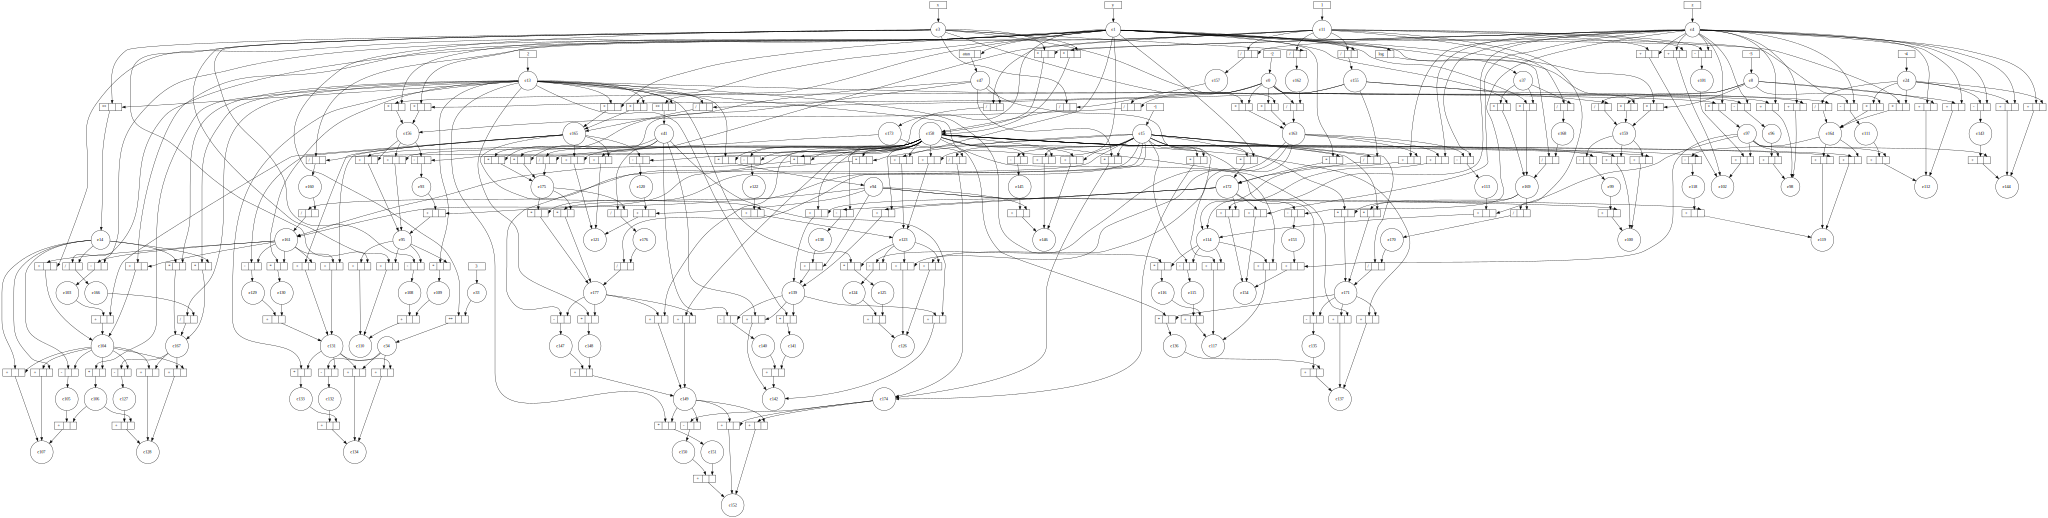

In [33]:
apply_rules(eg, rules)
eg.build_digraph()

In [2]:
def transform(node, copy=True):
    node = node.copy() if copy else node
    #print(node)
    #new_node = fun(node, *args, **kwargs)

    if node is None:
        raise ValueError("A transformed node cannot be None")
    if not isinstance(node, Expression):
        return Node(key=node, args=())

    non_empty_args = {k: v for k, v in node.args.items() if not if_empty(v)}
    new_node = Node(key=class_to_name(node), args=tuple())

    #for k, v in node.args.items():
    for k, v in non_empty_args.items():
        is_list_arg = isinstance(v, list)

        child_nodes = v if is_list_arg else [v]
        new_child_nodes = []

        for cn in child_nodes:
            if isinstance(cn, Expression):
                new_child_node = transform(cn)
                new_child_node.parent = new_node
                new_node.args += (new_child_node,)
            else:
                new_child_node = cn
                #new_node.args += (new_child_node,)
                new_node.args += (Node(key=k, args=(Node(new_child_node, ()), )), )
            new_child_nodes.append(new_child_node)

        #new_node.args += new_child_nodes if is_list_arg else new_child_nodes[0]
        #new_node.args[k] = new_child_nodes if is_list_arg else new_child_nodes[0]
    return new_node

In [18]:
text = 'SELECT T3.cell_mobile_number FROM candidates AS T1 JOIN candidate_assessments AS T2 ON T1.candidate_id = T2.candidate_id JOIN people AS T3 ON T1.candidate_id = T3.person_id WHERE T2.asessment_outcome_code = "Fail"'
text = 'SELECT course_id FROM courses ORDER BY course_id'
short_text = 'SELECT course_name FROM courses ORDER BY course_name'

tokens = Tokenizer().tokenize(text)
expression = Parser().parse(tokens)[0]
short_tokens = Tokenizer().tokenize(short_text)
short_expression = Parser().parse(short_tokens)[0]

kk = transform(expression)
short_kk = transform(short_expression)

Select
Column
Identifier
this
course_id
quoted
False
From
Table
Identifier
this
courses
quoted
False
Order
Ordered
Column
Identifier
this
course_id
quoted
False
Select
Column
Identifier
this
course_name
quoted
False
From
Table
Identifier
this
courses
quoted
False
Order
Ordered
Column
Identifier
this
course_name
quoted
False


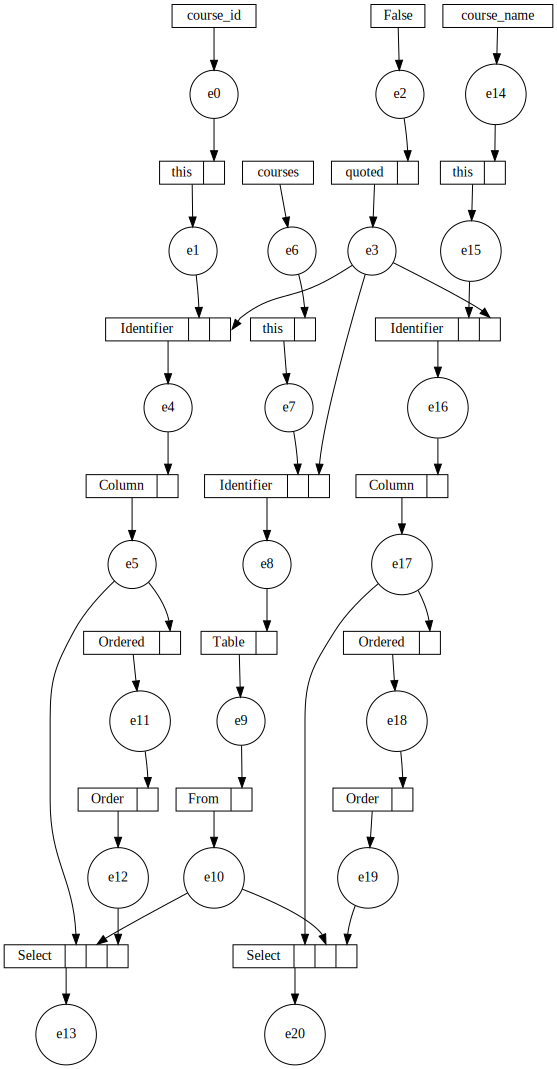

In [19]:
#eg = EGraph()
#eg.add_node(short_kk)
#graph = eg.build_digraph()
#graph.render('simple', format='png')
#
#eg = EGraph()
#eg.add_node(kk)
#graph = eg.build_digraph()
#graph.render('long', format='png')

eg = EGraph()
eg.add_node(kk)
eg.add_node(short_kk)
graph = eg.build_digraph()
#graph.render('combined', format='png')
graph

In [ ]:
def node_to_graph(node):
    node_id
    g = Digraph(node_attr={'shape': 'record', 'height': '.1'})

In [ ]:
def build_digraph(node):
    def format_record(x):
      if isinstance(x, list):
        return '{' + '|'.join(format_record(e) for e in x) + '}'
      else:
        return x
    def escape(x):
      return str(x).replace('<', '\<').replace('>', '\>')
    g = Digraph(node_attr={'shape': 'record', 'height': '.1'})
    for eclass, enodes in self.eclasses().items():
        g.node(f'{eclass.id}', label=f'e{eclass.id}', shape='circle')

        for enode in enodes:
          enode_id = str(id(enode))
          #g.edge(f'{eclass.id}', enode_id)
          g.edge(enode_id, f'{eclass.id}')

          record = [escape(enode.key)]
          for i, arg in enumerate(enode.args):
            #g.edge(f'{enode_id}:p{i}', f'{arg.id}')
            g.edge(f'{arg.id}', f'{enode_id}:p{i}')
            record.append(f'<p{i}>')
          g.node(enode_id, label='|'.join(record))

    return g